In [1]:
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
import ipyplot
import cv2

In [2]:
def read_pickle(pickle_file_path):
    with open(pickle_file_path, "rb") as pklfile:
        return pickle.load(pklfile)

In [3]:
pd.options.display.max_colwidth = None

In [4]:
%matplotlib widget

In [5]:
TRAIN_DATA_PATH = "F:/skripsi/FAS-Skripsi-4/embedding_data/ssdg_baseline_OCItoM_all_fixed/train_msu_mfsd.pkl"
TEST_DATA_PATH = "F:/skripsi/FAS-Skripsi-4/embedding_data/ssdg_baseline_OCItoM_all_fixed/test_msu_mfsd.pkl"

In [6]:
train_data = read_pickle(TRAIN_DATA_PATH)
train_img_paths = np.unique(np.asarray(train_data['img_paths']))
train_embs = np.asarray(train_data['main_embs'])
train_labels = np.asarray(train_data['labels'])

test_data = read_pickle(TEST_DATA_PATH)
test_img_paths = np.unique(np.asarray(test_data['img_paths']))
test_embs = np.asarray(test_data['main_embs'])
test_labels = np.asarray(test_data['labels'])

tsne2d = TSNE(n_components=2, perplexity=30, metric="cosine")

all_embs = np.concatenate((train_embs, test_embs), axis=0)
all_img_paths = np.concatenate((train_img_paths, test_img_paths), axis=0)

tsne_embs = tsne2d.fit_transform(all_embs)

tsne_train = tsne_embs[:train_embs.shape[0]]
tsne_test = tsne_embs[train_embs.shape[0]:]

train_spoof_types = []

for train_img_path in train_img_paths:
    if "real" in str(train_img_path).lower() or "live" in str(train_img_path).lower():
        train_spoof_types.append(1)
    elif "print" in str(train_img_path).lower():
        train_spoof_types.append(2)
    elif "video" in str(train_img_path).lower():
        train_spoof_types.append(3)

train_spoof_types = np.asarray(train_spoof_types)

test_spoof_types = []

for test_img_path in test_img_paths:
    if "real" in str(test_img_path).lower() or "live" in str(train_img_path).lower():
        test_spoof_types.append(1)
    elif "print" in str(test_img_path).lower():
        test_spoof_types.append(2)
    elif "video" in str(test_img_path).lower():
        test_spoof_types.append(3)

test_spoof_types = np.asarray(test_spoof_types)

all_spoof_types = np.concatenate((train_spoof_types, test_spoof_types), axis=0)

tsne_train_live = tsne_train[train_labels == 1]
tsne_train_print = tsne_train[train_spoof_types == 2]
tsne_train_screen = tsne_train[train_spoof_types == 3]

tsne_test_live = tsne_test[test_labels == 1]
tsne_test_print = tsne_test[test_spoof_types == 2]
tsne_test_screen = tsne_test[test_spoof_types == 3]

c:\Users\goldi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\goldi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'SSDG Baseline OCItoM Train & Test MSU-MFSD t-SNE')

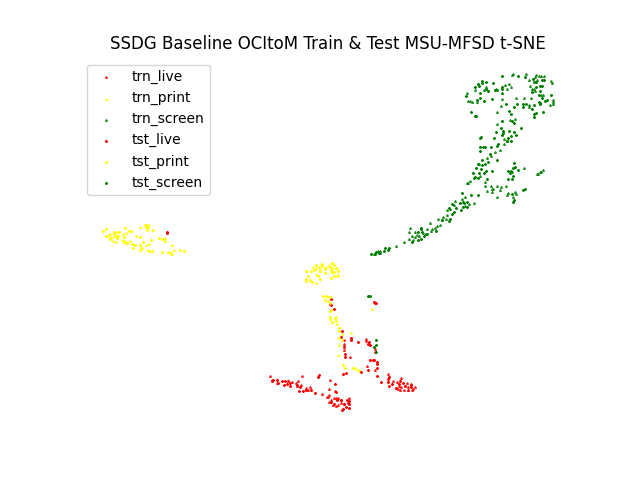

In [27]:
fig, ax = plt.subplots()

ax.scatter(tsne_train_live[:, 0],  tsne_train_live[:, 1], c="red", s=1, label="trn_live", marker="^")
ax.scatter(tsne_train_print[:, 0], tsne_train_print[:, 1], c="yellow", s=1, label="trn_print", marker="^")
ax.scatter(tsne_train_screen[:, 0], tsne_train_screen[:, 1], c="green", s=1, label="trn_screen", marker="^")

ax.scatter(tsne_test_live[:, 0], tsne_test_live[:, 1], c="red", s=1, label="tst_live", marker="X")
ax.scatter(tsne_test_print[:, 0], tsne_test_print[:, 1], c="yellow", s=1, label="tst_print", marker="X")
ax.scatter(tsne_test_screen[:, 0], tsne_test_screen[:, 1], c="green", s=1, label="tst_screen", marker="X")

ax.legend()
ax.axis("off")
ax.set_title(f"SSDG Baseline OCItoM Train & Test MSU-MFSD t-SNE")


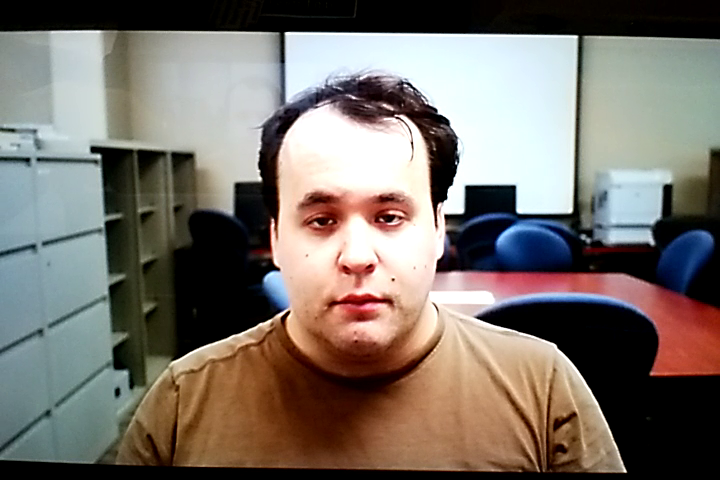
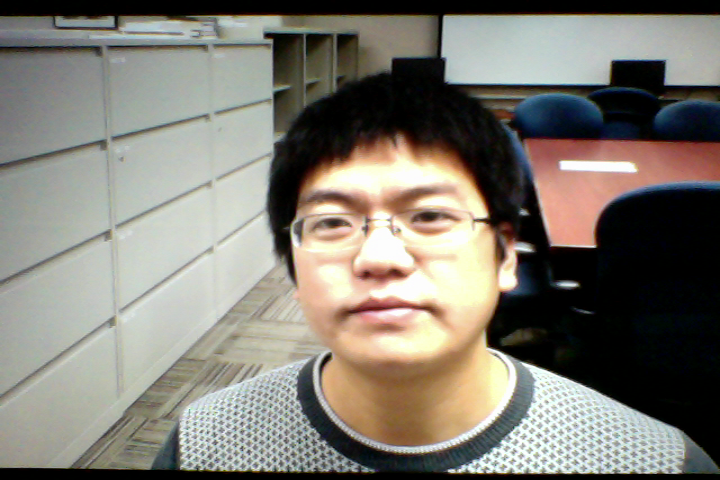
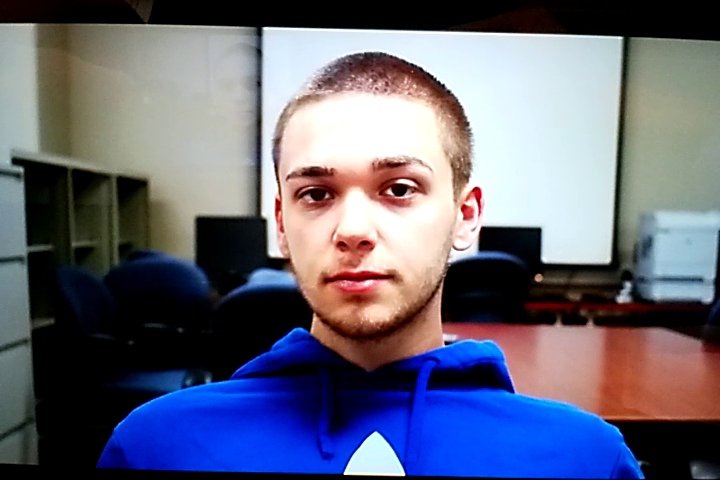
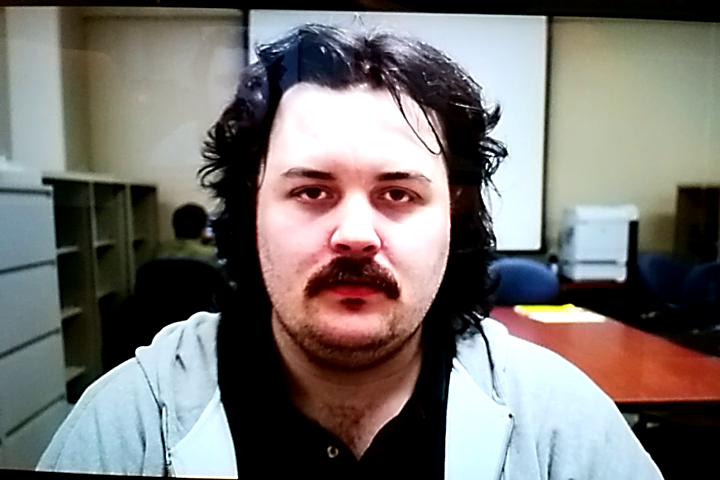
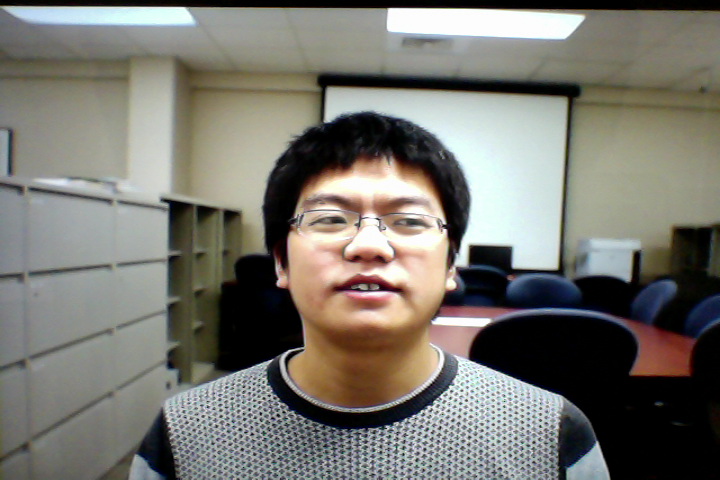
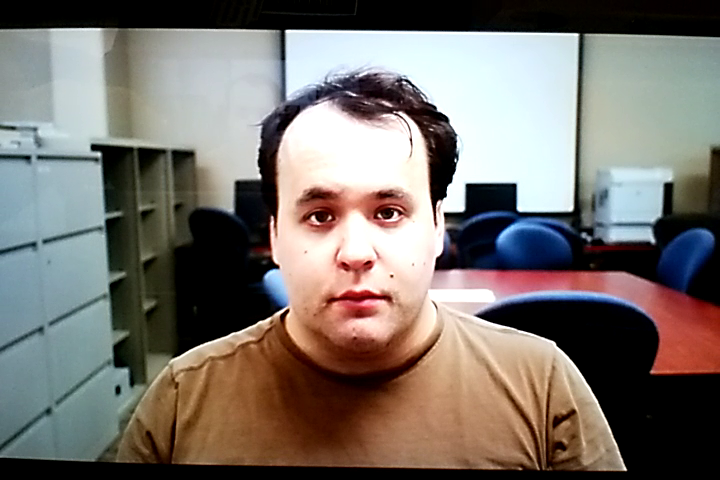


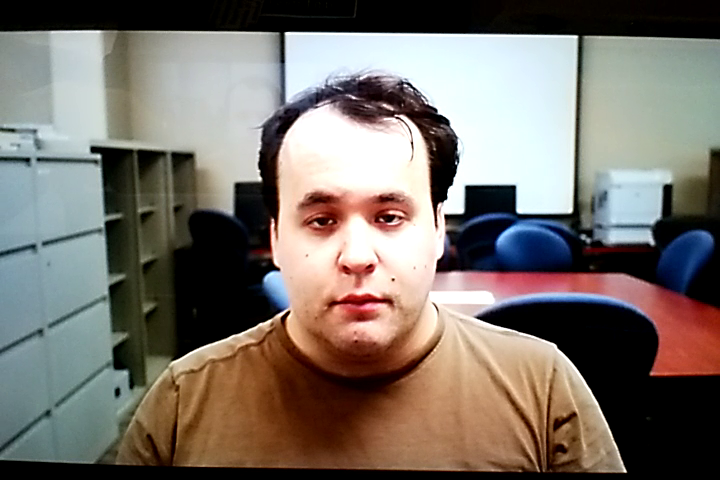
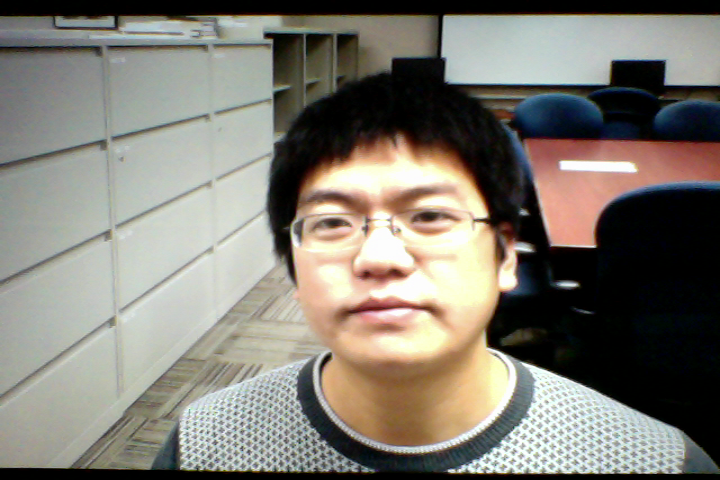
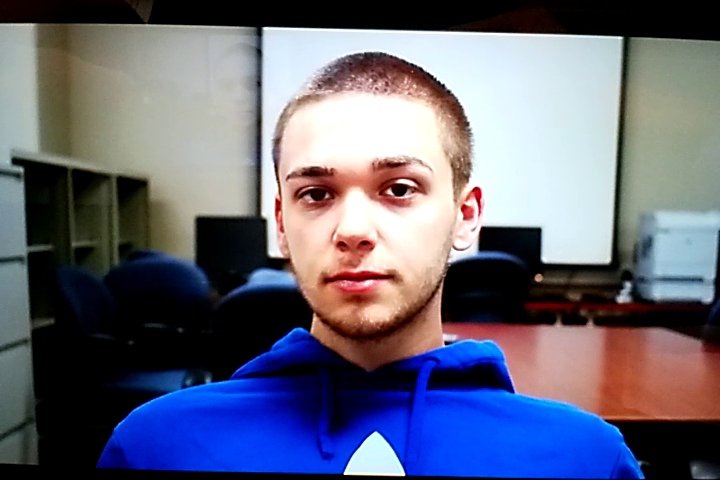
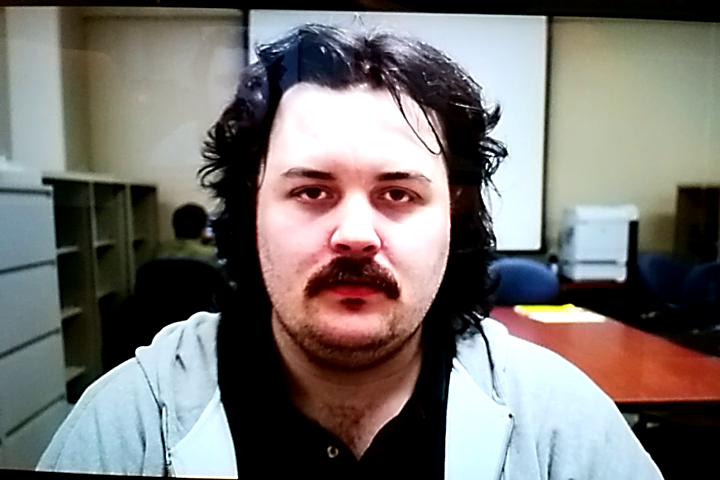
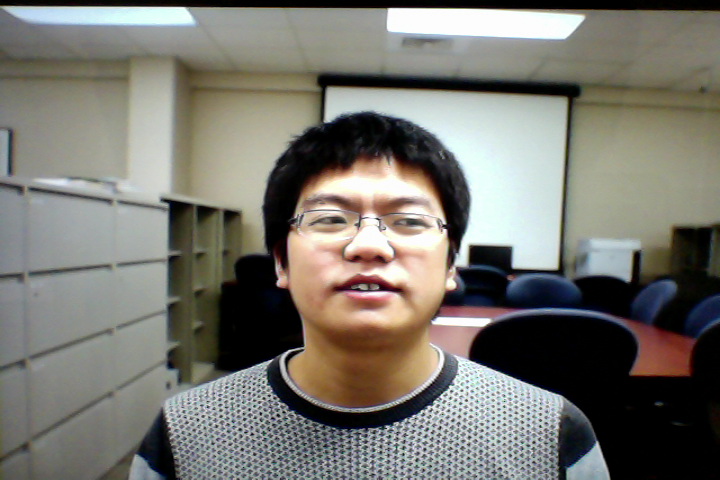
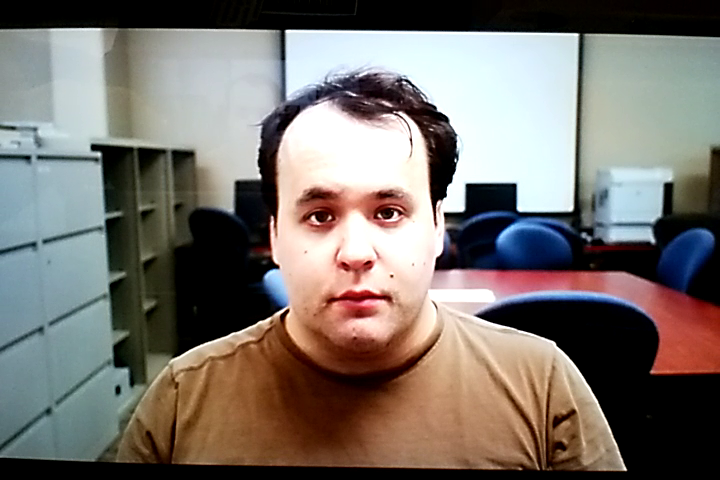

In [26]:
query_coordinates = [
   (3.30, 1.6),
]
num_nearest = 5
all_img_paths_temp = all_img_paths.copy()
all_spoof_types_temp = all_spoof_types.copy()

spoof_label = ["live", "print", "screen"]

for q_coord in query_coordinates:
   img_list = []
   label_list = []
   dist = cosine_distances(np.array([q_coord]), tsne_embs).ravel()
   
   for i in range(num_nearest+1):
      result_index = dist.argmin()
      # print(str(all_img_paths_temp[result_index]).lower())

      if i == 0:
         label_list.append(f"{spoof_label[int(all_spoof_types_temp[result_index])-1]} (Query)")
      else:
         label_list.append(f"{spoof_label[int(all_spoof_types_temp[result_index])-1]} ({i})")
      img = cv2.imread(str(all_img_paths_temp[result_index]))
      img = cv2.resize(img, (720, 480))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img_list.append(img)
      all_img_paths_temp = np.delete(all_img_paths_temp, [result_index])
      dist = np.delete(dist, [result_index])

   ipyplot.plot_images(img_list, label_list)